### Import package

In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(2)
tf.set_random_seed(2)

%matplotlib inline

### Hyperparameter

In [2]:
MAX_EPISODE = 100 # 要跑多少個 episode
MAX_EP_STEPS = 200 # 一個 episode 要跑多少步
DISPLAY_REWARD_THRESHOLD = -60 # 如果 reward 大於這個 threshold 就 render 環境
RENDER = False # 一開始先不要 render，因為會浪費時間
GAMMA = 0.95 # reward discount factor
LR_A = 0.0001 # learning rate for actor
LR_C = 0.001 # learning rate for critic

USE_ACTION_AS_INPUT = False # whether to use action as input for critic

### Environment Settings

In [3]:
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
env.seed(1) # reproducible

n_obs = env.observation_space.shape[0]
is_discrete = hasattr(env.action_space, "n")

if is_discrete:
    n_action_space = env.action_space.n
else:
    n_action_space = env.action_space.shape[0]
print("The number of observation is: %s The number of action that can be taken is: %s (%s)" % \
      (n_obs, n_action_space, "discrete" if is_discrete else "continuous"))

if not is_discrete:
    action_bound = env.action_space.high
    print("Action boundary: %s ~ %s" % (env.action_space.low[0], env.action_space.high[0]))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
The number of observation is: 3 The number of action that can be taken is: 1 (continuous)
Action boundary: -2.0 ~ 2.0


![](img/actor_critic_pseudo.JPG)

### Actor-Critic

In [4]:
class ActorCritic(object):
    def __init__(self, n_action_space, n_state, action_bound, sess):
        
        self.n_action_space = n_action_space
        self.n_state = n_state
        self.action_bound = action_bound
        self.sess = sess
        
        self.S = tf.placeholder(tf.float32, [1, self.n_state], 'state_input') 
        self.gt_action = tf.placeholder(tf.float32, None, 'gt_action') # groundtruth action
        self.td_error = tf.placeholder(tf.float32, None, name="td_error")  # TD_error
        
        self.R = tf.placeholder(tf.float32, name='reward')
        self.v_ = tf.placeholder(tf.float32, [1, 1], 'next_exp_v')
        
        with tf.variable_scope("Actor"):
            # create actor network
            self.action, self.normal_dist = self.create_actor(self.S)
            
            with tf.name_scope("expected_value_for_actor"):
                # actor gradient = grad[logPi(a|s) * td_error]
                self.exp_v = self.normal_dist.log_prob(self.gt_action) * self.td_error
                self.exp_v = self.exp_v - 0.01 * self.normal_dist.entropy() # Add cross entropy cost to encourage exploration
            
            with tf.name_scope("actor_train"):
                # wish to maximize Q value
                self.actor_train = tf.train.AdamOptimizer(learning_rate=LR_A).minimize(-self.exp_v) # min(-v) = max(v)
        
        with tf.variable_scope("Critic"):
            # create critic network
            self.v = self.create_critic(self.S, self.gt_action)
            
            with tf.name_scope("squared_TD_error"):
                # critic gradient = grad[r + gamma * V(s_) - V(s)]
                critic_v_target = self.R + GAMMA * self.v_
                self.critic_td_error = tf.reduce_mean(critic_v_target - self.v)
                self.loss = tf.square(self.critic_td_error)
            
            with tf.name_scope("critic_train"):
                # wish to minimize the td error
                self.critic_train = tf.train.AdamOptimizer(learning_rate=LR_C).minimize(self.loss) 
                
    def choose_action(self, s):
        s = s[np.newaxis, :]
        return self.sess.run(self.action, {self.S: s}) # return a action with continuous real number
    
    def create_actor(self, s):
        l1 = tf.layers.dense(s, units=30, activation=tf.nn.relu, name='l1')
        mu = tf.layers.dense(inputs=l1, units=1, activation=tf.nn.tanh, name='mu')
        sigma = tf.layers.dense(inputs=l1, units=1, activation=tf.nn.softplus, name='sigma')
        normal_dist = tf.distributions.Normal(tf.squeeze(mu*2), tf.squeeze(sigma + 1e-5))
        # action = tf.clip_by_value(normal_dist.sample(1), -self.action_bound[0], -self.action_bound[0], name='policy_action')
        action = tf.multiply(normal_dist.sample(1), self.action_bound, name='policy_action')
        return action, normal_dist
        
    def update_actor(self, s, a , td):
        s = s[np.newaxis, :]
        feed_dict = {self.S: s, self.gt_action: a, self.td_error: td}
        _, exp_v = self.sess.run([self.actor_train, self.exp_v], feed_dict)
        return exp_v
        
    def create_critic(self, s, a):
        l1 = tf.layers.dense(inputs=s, units=30, activation=tf.nn.relu, name='l1')
        if USE_ACTION_AS_INPUT:
            a = tf.reshape(a, (1, 1))
            l2 = tf.layers.dense(inputs=tf.concat([l1, a], axis=1), units=20, activation=tf.nn.relu, name="l2")
            v = tf.layers.dense(inputs=l2, units=1, activation=None, name="value")
        else:
            v = tf.layers.dense(inputs=l1, units=1, activation=None, name="value")
        return v
    
    def update_critic(self, s, r, s_, a=None):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]
        
        if a is None:
            v_ = self.sess.run(self.v, {self.S: s_})
            td_error, _ = self.sess.run([self.critic_td_error, self.critic_train],
                                              {self.S: s, self.v_: v_, self.R: r})
        else:
            v_ = self.sess.run(self.v, {self.S: s_, self.gt_action: a})
            td_error, _ = self.sess.run([self.critic_td_error, self.critic_train],
                                              {self.S: s, self.gt_action: a, self.v_: v_, self.R: r})          
        return td_error


![](img/log_actor_critic.png)

### Initial our Actor-Critic

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

actor_critic = ActorCritic(n_action_space, n_obs, action_bound, sess)

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("D:/temp/log_actor_critic/", graph=sess.graph)

### Main training

In [6]:
reward_history = []
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t, ep_rs = 0, 0
    while True:
        if RENDER:
            env.render()
        a = actor_critic.choose_action(s)
        s_, r, done, info = env.step(a)
        r /= 10 # scaled reward to converge faster
        if USE_ACTION_AS_INPUT:
            td_error = actor_critic.update_critic(s, r, s_, a)
        else:
            td_error = actor_critic.update_critic(s, r, s_) # critic gradient = grad[r + gamma * V(s_) - V(s)]
        actor_critic.update_actor(s, a, td_error) # actor gradient = grad[logPi(a|s) * td_error]

        s = s_
        t += 1
        ep_rs += r
        
        if t > MAX_EP_STEPS:
            reward_history.append(ep_rs)
            if 'running_reward' not in globals():
                running_reward = ep_rs
            else:
                running_reward = running_reward * 0.9 + ep_rs * 0.1 # 希望是穩定的 reward
            
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))
            break

episode: 0   reward: -161
episode: 1   reward: -159
episode: 2   reward: -159
episode: 3   reward: -158
episode: 4   reward: -159
episode: 5   reward: -158
episode: 6   reward: -157
episode: 7   reward: -156
episode: 8   reward: -156
episode: 9   reward: -152
episode: 10   reward: -152
episode: 11   reward: -155
episode: 12   reward: -158
episode: 13   reward: -161
episode: 14   reward: -162
episode: 15   reward: -165
episode: 16   reward: -167
episode: 17   reward: -167
episode: 18   reward: -166
episode: 19   reward: -164
episode: 20   reward: -165
episode: 21   reward: -165
episode: 22   reward: -165
episode: 23   reward: -167
episode: 24   reward: -163
episode: 25   reward: -160
episode: 26   reward: -159
episode: 27   reward: -161
episode: 28   reward: -159
episode: 29   reward: -158
episode: 30   reward: -156
episode: 31   reward: -157
episode: 32   reward: -157
episode: 33   reward: -158
episode: 34   reward: -157
episode: 35   reward: -155
episode: 36   reward: -156
episode: 37

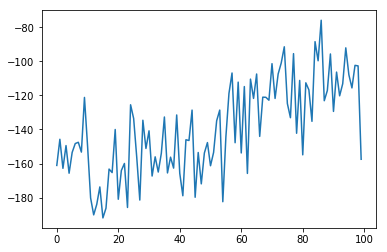

In [7]:
plt.plot(reward_history)

In [8]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
# Save the variables to disk.
save_path = saver.save(sess, "checkpoint/ac_v1.ckpt")

### Use checkpoint
這裡有幫大家跑好 `USE_ACTION_AS_INPUT = False` 的 model，有興趣的話可以 restore ac.ckpt 這個 checkpoint 來玩 pendulum。

In [9]:
saver.restore(sess, "checkpoint/ac_v1.ckpt")
s = env.reset()
i_step = 0
while True:
    env.render()
    a = actor_critic.choose_action(s)
    s_, r, done, info = env.step(a)
    s = s_
    i_step += 1
    if i_step > 300:
        break

INFO:tensorflow:Restoring parameters from checkpoint/ac_v1.ckpt


In [ ]:
# 啟動TensorBoard
!tensorboard --logdir=D:/temp/log_actor_critic/ --debug